In [18]:
import torch 
import numpy as np 
import VirusDataset 
import ioutils 
import random 
import pickle
import pandas as pd
import torch.utils
from torch.utils.data import DataLoader
import pytorch_lightning as L
import importlib 
import testUtils
import os 
import json 
import trainUtils
import matplotlib.pyplot as plt
from scipy import stats
importlib.reload(VirusDataset)
importlib.reload(testUtils)

Epoch 0:   0%|          | 0/32 [51:00:45<?, ?it/s]


<module 'testUtils' from '/home/tyfei/ionChannel/testUtils.py'>

In [22]:
a = torch.tensor(np.arange(-5, 5, 0.2))
a, torch.sigmoid(a)

(tensor([-5.0000e+00, -4.8000e+00, -4.6000e+00, -4.4000e+00, -4.2000e+00,
         -4.0000e+00, -3.8000e+00, -3.6000e+00, -3.4000e+00, -3.2000e+00,
         -3.0000e+00, -2.8000e+00, -2.6000e+00, -2.4000e+00, -2.2000e+00,
         -2.0000e+00, -1.8000e+00, -1.6000e+00, -1.4000e+00, -1.2000e+00,
         -1.0000e+00, -8.0000e-01, -6.0000e-01, -4.0000e-01, -2.0000e-01,
          4.4409e-15,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01,
          1.0000e+00,  1.2000e+00,  1.4000e+00,  1.6000e+00,  1.8000e+00,
          2.0000e+00,  2.2000e+00,  2.4000e+00,  2.6000e+00,  2.8000e+00,
          3.0000e+00,  3.2000e+00,  3.4000e+00,  3.6000e+00,  3.8000e+00,
          4.0000e+00,  4.2000e+00,  4.4000e+00,  4.6000e+00,  4.8000e+00],
        dtype=torch.float64),
 tensor([0.0067, 0.0082, 0.0100, 0.0121, 0.0148, 0.0180, 0.0219, 0.0266, 0.0323,
         0.0392, 0.0474, 0.0573, 0.0691, 0.0832, 0.0998, 0.1192, 0.1419, 0.1680,
         0.1978, 0.2315, 0.2689, 0.3100, 0.3543, 0.4013, 0.4502, 0.

### all models
1. adversial 
2. logit / mask_weight = 0.0/0.1 
3. list  
4. timing
5. --model   
6. combination 
7. 

In [144]:
def a(t, w, s=5, q=7):
    print(t, w, s, q) 
def b(i = 1, *args, **kwargs):
    print(i, args, kwargs)
    a(s = 4, *args, **kwargs)
b(3, 5, 7)

3 (5, 7) {}
5 7 4 7


### test labels 
test on validation set

In [98]:
# 42901
df = pd.read_excel("./temp/v1_pure_20241113.xlsx", sheet_name="Gating")
df["num"]/42901

0    0.775996
1    0.057201
2    0.131302
3    0.226312
Name: num, dtype: float64

In [2]:
path = "/data2/tyfei/trainresults/ionChannels/ESMCFinal/adversial+logit"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [3]:
pretrain_model = trainUtils.loadPretrainModel(configs)
model = trainUtils.buildModel(configs, pretrain_model)

initized model for base_learning stage


In [4]:
ds = trainUtils.loadDataset(configs)

In [5]:
ckpt = torch.load("/data2/tyfei/trainresults/ionChannels/ESMCFinal/adversial+logit/last.ckpt")
model.load_state_dict(ckpt['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['esm_model.embed.weight', 'esm_model.transformer.blocks.0.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.0.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.0.ffn.0.weight', 'esm_model.transformer.blocks.0.ffn.0.bias', 'esm_model.transformer.blocks.0.ffn.1.linear.weight', 'esm_model.transformer.blocks.0.ffn.3.linear.weight', 'esm_model.transformer.blocks.1.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.1.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.1.ffn.0.weight', 'esm_model.transformer.blocks.1.ffn.0.bias', 'esm_model.transformer.blocks.1.ffn.1.linear.weight', 'esm_model.transformer.blocks.1.ffn.3.linear.weight', 'esm_model.transformer.blocks.2.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.2.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.2.ffn.0.weight', 'esm_model.transformer.blocks.2.ffn.0.bias', 'esm_model.transformer.blocks.2.ffn.1.linear.weight', 'es

In [11]:
t = L.Trainer(devices=[0])
dl = ds.predict_dataloader()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


get predict loader


In [8]:
for i in range(len(ds.val_set.data2)):
    ds.val_set.data2[i] = ds.val_set.data2[i][:2]

In [9]:
ds.val_set.sample = False

In [10]:
from torch.utils.data import DataLoader, Dataset
val = ds.val_set 
val.shuffle = True
dl = DataLoader(val, batch_size=1, shuffle=True, num_workers=8)

In [12]:
res1 = t.predict(model, dl)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 4520/4520 [05:24<00:00, 13.92it/s]


In [154]:
len(res2)

4520

In [13]:
df1 = [] 
df2 = [] 
for i in range(len(res1)):
    d1 = res1[i][0][1].numpy()
    d2 = res1[i][1].squeeze().numpy()
    # print(d1, d2)
    if d2[1] >= 0:
        df1.append(d1)
        df2.append(d2[1:])
    # df1.append(res[i][0])
    # df2.append(res[i][1])
df1 = np.array(df1)
df2 = np.array(df2)
df1 = pd.DataFrame(df1, columns=configs["dataset"]["required_labels"])
df2 = pd.DataFrame(df2, columns=configs["dataset"]["required_labels"])

In [25]:
# without pos weights
import torchmetrics 
acc = torchmetrics.AUROC(task="binary")
corr = torchmetrics.SpearmanCorrCoef()
cnt = 0
without_pos = {}
for i in df1.columns:
    print(cnt, i)
    cnt += 1
    subdf1 = df1[df2[i] != -1]
    subdf2 = df2[df2[i] != -1]
    print("f1", acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)))
    without_pos[i] = acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)).item()
    print("corr", corr(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values).float()))
    print(sum(df2[i])/len(df2[i]))
# acc(torch.tensor(df1["Ligand-gated"]), torch.tensor(df2["Ligand-gated"]))

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


0 Voltage-gated
f1 tensor(0.6591)
corr tensor(0.2394)
0.2525005556790398
1 Ligand-gated
f1 tensor(0.3854)
corr tensor(-0.1768)
0.7274949988886419
2 Mechanically-gated
f1 tensor(0.7689)
corr tensor(0.2455)
0.07512780617915092
3 Other gating
f1 tensor(0.5994)
corr tensor(0.1252)
0.15692376083574128
4 plasma membrane
f1 tensor(0.6782)
corr tensor(0.1562)
0.9313180706823738
5 endoplasmic reticulum
f1 tensor(0.8577)
corr tensor(0.2757)
0.05223382973994221
6 endosome
f1 tensor(0.8773)
corr tensor(0.2361)
0.03378528561902645
7 apical membrane
f1 tensor(0.6152)
corr tensor(0.0886)
0.05201155812402756
8 golgi
f1 tensor(0.9030)
corr tensor(0.1078)
0.006001333629695488
9 mitochondria
f1 tensor(0.3891)
corr tensor(-0.0801)
0.04556568126250278
10 lysosome
f1 tensor(0.2611)
corr tensor(-0.0493)
0.003556345854634363
11 K+
f1 tensor(0.7003)
corr tensor(0.3443)
0.461213603022894
12 Ca2+
f1 tensor(0.8797)
corr tensor(0.6331)
0.27739497666148033
13 Na+
f1 tensor(0.8990)
corr tensor(0.6800)
0.320960213380

In [121]:
without_pos

{'Voltage-gated': 0.4349021017551422,
 'Ligand-gated': 0.8491751551628113,
 'Mechanically-gated': 0.0,
 'Other gating': 0.0,
 'plasma membrane': 0.9644377827644348,
 'endoplasmic reticulum': 0.0,
 'endosome': 0.0,
 'apical membrane': 0.0,
 'golgi': 0.0,
 'mitochondria': 0.0,
 'lysosome': 0.0,
 'K+': 0.5983210206031799,
 'Ca2+': 0.7344854474067688,
 'Na+': 0.7472454309463501,
 'Mg2+': 0.7440500855445862,
 'Cl-': 0.02373887225985527,
 'H+': 0.8240306973457336,
 'Zn2+': 0.7663755416870117,
 'F-': 0.0,
 'Selectivity': 0.9482842087745667}

In [14]:
# with pos weights
import torchmetrics 
acc = torchmetrics.AUROC(task="binary")
corr = torchmetrics.SpearmanCorrCoef()
cnt = 0
with_pos = {}
cnts = {}
for i in df1.columns:
    print(cnt, i)
    cnt += 1
    subdf1 = df1[df2[i] != -1]
    subdf2 = df2[df2[i] != -1]
    print("f1", acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)))
    with_pos[i] = acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)).item()
    cnts[i] = subdf2[i].sum()
    cnts[i] /= len(subdf2[i])
    print("corr", corr(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values).float()))
    print(sum(df2[i])/len(df2[i]))
# acc(torch.tensor(df1["Ligand-gated"]), torch.tensor(df2["Ligand-gated"]))

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


0 Voltage-gated
f1 tensor(0.7274)
corr tensor(0.3422)
0.2525005556790398
1 Ligand-gated
f1 tensor(0.3585)
corr tensor(-0.2182)
0.7274949988886419
2 Mechanically-gated
f1 tensor(0.8828)
corr tensor(0.3495)
0.07512780617915092
3 Other gating
f1 tensor(0.7145)
corr tensor(0.2703)
0.15692376083574128
4 plasma membrane
f1 tensor(0.7805)
corr tensor(0.2458)
0.9313180706823738
5 endoplasmic reticulum
f1 tensor(0.8398)
corr tensor(0.2619)
0.05223382973994221
6 endosome
f1 tensor(0.9222)
corr tensor(0.2642)
0.03378528561902645
7 apical membrane
f1 tensor(0.8713)
corr tensor(0.2856)
0.05201155812402756
8 golgi
f1 tensor(0.9529)
corr tensor(0.1212)
0.006001333629695488
9 mitochondria
f1 tensor(0.6529)
corr tensor(0.1105)
0.04556568126250278
10 lysosome
f1 tensor(0.3789)
corr tensor(-0.0250)
0.003556345854634363
11 K+
f1 tensor(0.6727)
corr tensor(0.2969)
0.461213603022894
12 Ca2+
f1 tensor(0.8285)
corr tensor(0.5477)
0.27739497666148033
13 Na+
f1 tensor(0.8884)
corr tensor(0.6621)
0.3209602133807

In [201]:
(1-0.6294732162702823)/0.6294732162702823

0.5886299435028248

In [27]:
df_proportion = pd.read_excel("./temp/proportion.xlsx", index_col=0)
df_proportion["pos_weights"] = (1-df_proportion["Unnamed: 2"]) / df_proportion["Unnamed: 2"]
df_proportion


,num,Unnamed: 2,pos_weights
Ion_type,,,
Ca2+,15566,0.362835,1.756071
Cl-,5471,0.127526,6.841528
F-,3459,0.080627,11.402718
H+,12378,0.288525,2.465907
K+,24656,0.574719,0.739982
Mg2+,13885,0.323652,2.089737
Na+,16673,0.388639,1.573082
Zn2+,11832,0.275798,2.625845
Ligand-gated,33291,0.775996,0.288667


In [30]:
with_withoutpos = pd.DataFrame([without_pos, with_pos], index=["without_pos", "with_pos"]).T
with_withoutpos["pwt"] = [
                3.41868370e+00,
                2.88666607e-01,
                1.64820701e+01,
                6.61601278e+00,
                5.89440427e-02,
                1.69878407e+01,
                2.39279489e+01,
                2.54331485e+01,
                2.20139175e+02,
                1.81266161e+01,
                1.38742671e+02,
                7.39982154e-01,
                1.75607092e+00,
                1.57308223e+00,
                2.08973713e+00,
                6.84152806e+00,
                2.46590725e+00,
                2.62584517e+00,
                1.14027175e+01,
                1.0
            ]
with_withoutpos["pw"] = df_proportion["pos_weights"]
with_withoutpos

,without_pos,with_pos,pwt,pw
Voltage-gated,0.659082,0.790340,3.418684,3.418684
Ligand-gated,0.385399,0.606033,0.288667,0.288667
Mechanically-gated,0.768854,0.976156,16.482070,16.482070
Other gating,0.599384,0.774145,6.616013,6.616013
plasma membrane,0.678239,0.885477,0.058944,0.058944
endoplasmic reticulum,0.857666,0.972002,16.987841,16.987841
endosome,0.877307,0.976062,23.927949,23.927949
apical membrane,0.615224,0.984209,25.433149,25.433148
golgi,0.902968,0.976123,220.139175,220.139175
mitochondria,0.389092,0.695216,18.126616,18.126616


In [175]:
with_withoutpos = pd.DataFrame([without_pos, with_pos], index=["without_pos", "with_pos"]).T
with_withoutpos["pwt"] = [
                3.41868370e+00,
                2.88666607e-01,
                1.64820701e+01,
                6.61601278e+00,
                5.89440427e-02,
                1.69878407e+01,
                2.39279489e+01,
                2.54331485e+01,
                2.20139175e+02,
                1.81266161e+01,
                1.38742671e+02,
                7.39982154e-01,
                1.75607092e+00,
                1.57308223e+00,
                2.08973713e+00,
                6.84152806e+00,
                2.46590725e+00,
                2.62584517e+00,
                1.14027175e+01,
                1.0
            ]
with_withoutpos["pw"] = df_proportion["pos_weights"]
with_withoutpos

,without_pos,with_pos,pwt,pw
Voltage-gated,0.779113,0.734662,3.418684,3.418684
Ligand-gated,0.646944,0.694136,0.288667,0.288667
Mechanically-gated,0.607819,0.969284,16.482070,16.482070
Other gating,0.786155,0.705143,6.616013,6.616013
plasma membrane,0.510178,0.898205,0.058944,0.058944
endoplasmic reticulum,0.761942,0.925079,16.987841,16.987841
endosome,0.634617,0.942743,23.927949,23.927949
apical membrane,0.520840,0.987177,25.433149,25.433148
golgi,0.908699,0.961919,220.139175,220.139175
mitochondria,0.445718,0.621742,18.126616,18.126616


In [199]:
with_withoutpos = pd.DataFrame([without_pos, with_pos], index=["without_pos", "with_pos"]).T
with_withoutpos["pwt"] = [
                3.41868370e+00,
                2.88666607e-01,
                1.64820701e+01,
                6.61601278e+00,
                5.89440427e-02,
                1.69878407e+01,
                2.39279489e+01,
                2.54331485e+01,
                2.20139175e+02,
                1.81266161e+01,
                1.38742671e+02,
                7.39982154e-01,
                1.75607092e+00,
                1.57308223e+00,
                2.08973713e+00,
                6.84152806e+00,
                2.46590725e+00,
                2.62584517e+00,
                1.14027175e+01,
                1.0
            ]
with_withoutpos["pw"] = df_proportion["pos_weights"]
with_withoutpos

,without_pos,with_pos,pwt,pw
Voltage-gated,0.734869,0.843759,3.418684,3.418684
Ligand-gated,0.688017,0.723625,0.288667,0.288667
Mechanically-gated,0.763815,0.963530,16.482070,16.482070
Other gating,0.779312,0.741964,6.616013,6.616013
plasma membrane,0.632007,0.899260,0.058944,0.058944
endoplasmic reticulum,0.795577,0.956634,16.987841,16.987841
endosome,0.879298,0.984598,23.927949,23.927949
apical membrane,0.603763,0.925981,25.433149,25.433148
golgi,0.843172,0.969622,220.139175,220.139175
mitochondria,0.412417,0.707395,18.126616,18.126616


In [29]:
with_withoutpos.mean()

without_pos     0.717276
with_pos        0.831651
pwt            25.035832
pw             26.300876
dtype: float64

In [142]:
with_withoutpos["cnts"] = cnts 
with_withoutpos["pwc"] = (1-with_withoutpos["cnts"]) / with_withoutpos["cnts"]
with_withoutpos

,without_pos,with_pos,pwt,pw,cnts,pwc
Voltage-gated,0.434902,0.608398,1.0,3.418684,0.252501,2.960387
Ligand-gated,0.849175,0.842254,1.0,0.288667,0.727495,0.374580
Mechanically-gated,0.000000,0.884488,5.0,16.482070,0.075128,12.310651
Other gating,0.000000,0.000000,2.0,6.616013,0.156924,5.372521
plasma membrane,0.964438,0.964319,1.0,0.058944,0.931318,0.073747
endoplasmic reticulum,0.000000,0.680965,5.0,16.987841,0.052234,18.144681
endosome,0.000000,0.467290,10.0,23.927949,0.033785,28.598684
apical membrane,0.000000,0.989201,40.0,25.433148,0.052012,18.226496
golgi,0.000000,0.239316,5.0,220.139175,0.006001,165.629630
mitochondria,0.000000,0.000000,30.0,18.126616,0.045566,20.946341


In [138]:
with_withoutpos["pw"].values

array([3.41868370e+00, 2.88666607e-01, 1.64820701e+01, 6.61601278e+00,
       5.89440427e-02, 1.69878407e+01, 2.39279489e+01, 2.54331485e+01,
       2.20139175e+02, 1.81266161e+01, 1.38742671e+02, 7.39982154e-01,
       1.75607092e+00, 1.57308223e+00, 2.08973713e+00, 6.84152806e+00,
       2.46590725e+00, 2.62584517e+00, 1.14027175e+01,            nan])

In [53]:
import torchmetrics 
acc = torchmetrics.Accuracy(task="binary", threshold=0.5)
corr = torchmetrics.SpearmanCorrCoef()
for i in df1.columns:
    print(i)
    subdf1 = df1[df2[i] != -1]
    subdf2 = df2[df2[i] != -1]
    print("acc", acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)))
    print("corr", corr(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values).float()))
    print(sum(df2[i])/len(df2[i]))
# acc(torch.tensor(df1["Ligand-gated"]), torch.tensor(df2["Ligand-gated"]))

Voltage-gated
acc tensor(0.6344)
corr tensor(0.2394)
0.2525005556790398
Ligand-gated
acc tensor(0.7439)
corr tensor(-0.1768)
0.7274949988886419
Mechanically-gated
acc tensor(0.9249)
corr tensor(0.2455)
0.07512780617915092
Other gating
acc tensor(0.8431)
corr tensor(0.1252)
0.15692376083574128
plasma membrane
acc tensor(0.9313)
corr tensor(0.1562)
0.9313180706823738
endoplasmic reticulum
acc tensor(0.9478)
corr tensor(0.2757)
0.05223382973994221
endosome
acc tensor(0.9662)
corr tensor(0.2361)
0.03378528561902645
apical membrane
acc tensor(0.9480)
corr tensor(0.0886)
0.05201155812402756
golgi
acc tensor(0.9940)
corr tensor(0.1078)
0.006001333629695488
mitochondria
acc tensor(0.9544)
corr tensor(-0.0801)
0.04556568126250278
lysosome
acc tensor(0.9964)
corr tensor(-0.0493)
0.003556345854634363
K+
acc tensor(0.6251)
corr tensor(0.3443)
0.461213603022894
Ca2+
acc tensor(0.8395)
corr tensor(0.6331)
0.27739497666148033
Na+
acc tensor(0.8203)
corr tensor(0.6800)
0.32096021338075126
Mg2+
acc ten

In [87]:
import torchmetrics 
acc = torchmetrics.Accuracy(task="binary", threshold=0.5)
corr = torchmetrics.SpearmanCorrCoef()
for i in df1.columns:
    print(i)
    subdf1 = df1[df2[i] != -1]
    subdf2 = df2[df2[i] != -1]
    print("acc", acc(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values)))
    print("corr", corr(torch.tensor(subdf1[i].values), torch.tensor(subdf2[i].values).float()))
    print(sum(df2[i])/len(df2[i]))
# acc(torch.tensor(df1["Ligand-gated"]), torch.tensor(df2["Ligand-gated"]))

Voltage-gated
acc tensor(0.9229)
corr tensor(0.)
1.0
Ligand-gated
acc tensor(0.7009)
corr tensor(0.7585)
0.7009345794392523
Mechanically-gated
acc tensor(1.)
corr tensor(0.)
0.0
Other gating
acc tensor(1.)
corr tensor(0.)
0.0
plasma membrane
acc tensor(0.9276)
corr tensor(0.4318)
0.9135514018691588
endoplasmic reticulum
acc tensor(0.9276)
corr tensor(0.4411)
0.08878504672897196
endosome
acc tensor(0.9836)
corr tensor(0.0813)
0.002336448598130841
apical membrane
acc tensor(1.)
corr tensor(0.)
0.0
golgi
acc tensor(0.9416)
corr tensor(0.3828)
0.07009345794392523
mitochondria
acc tensor(0.9626)
corr tensor(0.0558)
0.037383177570093455
lysosome
acc tensor(1.)
corr tensor(0.)
0.0
K+
acc tensor(0.7757)
corr tensor(0.5148)
0.25
Ca2+
acc tensor(0.9696)
corr tensor(0.3063)
0.04672897196261682
Na+
acc tensor(0.8318)
corr tensor(0.5774)
0.17757009345794392
Mg2+
acc tensor(0.9860)
corr tensor(0.0836)
0.002336448598130841
Cl-
acc tensor(0.9836)
corr tensor(0.)
0.0
H+
acc tensor(0.7850)
corr tensor(0

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [31]:
import torchmetrics 
acc = torchmetrics.Accuracy(task="binary", threshold=0.5)
corr = torchmetrics.SpearmanCorrCoef()
for i in df1.columns:
    print(i)
    print("acc", acc(torch.tensor(df1[i]), torch.tensor(df2[i])))
    print("corr", corr(torch.tensor(df1[i]), torch.tensor(df2[i]).float()))
    print(sum(df2[i])/len(df2[i]))
# acc(torch.tensor(df1["Ligand-gated"]), torch.tensor(df2["Ligand-gated"]))

Voltage-gated
acc tensor(0.8796)
corr tensor(0.)
1.0
Ligand-gated
acc tensor(0.6644)
corr tensor(0.5892)
0.6643518518518519
Mechanically-gated
acc tensor(1.)
corr tensor(0.)
0.0
Other gating
acc tensor(1.)
corr tensor(0.)
0.0
plasma membrane
acc tensor(0.9097)
corr tensor(0.3451)
0.9097222222222222
endoplasmic reticulum
acc tensor(0.9375)
corr tensor(0.4301)
0.09027777777777778
endosome
acc tensor(0.9977)
corr tensor(0.0805)
0.0023148148148148147
apical membrane
acc tensor(1.)
corr tensor(0.)
0.0
golgi
acc tensor(0.9282)
corr tensor(0.4301)
0.07175925925925926
mitochondria
acc tensor(0.9653)
corr tensor(0.2781)
0.034722222222222224
lysosome
acc tensor(0.9977)
corr tensor(0.0801)
0.0023148148148148147
K+
acc tensor(0.7731)
corr tensor(0.1225)
0.25925925925925924
Ca2+
acc tensor(0.9074)
corr tensor(0.3032)
0.05092592592592592
Na+
acc tensor(0.8704)
corr tensor(0.4030)
0.17592592592592593
Mg2+
acc tensor(0.9282)
corr tensor(0.0763)
0.0023148148148148147
Cl-
acc tensor(0.9861)
corr tensor(

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


### test bayes sampling

In [34]:
corr1 = torchmetrics.PearsonCorrCoef()
corr2 = torchmetrics.SpearmanCorrCoef()

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [31]:
df1 = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMC/logit2_with_list/test885_epoch=2-validate_acc=0.9595.csv")
df1.head()

,Voltage-gated,Ligand-gated,Mechanically-gated,Other gating,plasma membrane,endoplasmic reticulum,endosome,apical membrane,golgi,mitochondria,...,K+,Ca2+,Na+,Mg2+,Cl-,H+,Zn2+,F-,Selectivity,prediction
0,0.503973,0.474232,0.210620,0.209181,0.565233,0.430196,0.303895,0.147165,0.397557,0.155297,...,0.664662,0.464462,0.607866,0.432499,0.356559,0.694970,0.406146,0.383333,0.392223,0.374049
1,0.503971,0.474243,0.210615,0.209174,0.565217,0.430190,0.303885,0.147157,0.397544,0.155286,...,0.664690,0.464482,0.607860,0.432519,0.356543,0.694998,0.406166,0.383318,0.392195,0.373842
2,0.503975,0.474188,0.210704,0.209244,0.565128,0.430319,0.304010,0.147252,0.397665,0.155387,...,0.664669,0.464527,0.607902,0.432551,0.356630,0.695008,0.406244,0.383350,0.392161,0.374199
3,0.503973,0.474165,0.210749,0.209278,0.565073,0.430386,0.304073,0.147299,0.397726,0.155435,...,0.664671,0.464558,0.607922,0.432578,0.356671,0.695025,0.406294,0.383362,0.392135,0.374937
4,0.503974,0.474176,0.210730,0.209264,0.565095,0.430359,0.304047,0.147279,0.397700,0.155415,...,0.664671,0.464547,0.607913,0.432568,0.356654,0.695018,0.406274,0.383356,0.392145,0.373485


In [32]:
df2 = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMC/logit2_with_list/test885_epoch=4-validate_acc=0.9646.csv")
df2.head()

,Voltage-gated,Ligand-gated,Mechanically-gated,Other gating,plasma membrane,endoplasmic reticulum,endosome,apical membrane,golgi,mitochondria,...,K+,Ca2+,Na+,Mg2+,Cl-,H+,Zn2+,F-,Selectivity,prediction
0,0.453323,0.526447,0.148091,0.192247,0.743023,0.248887,0.166690,0.092227,0.219580,0.101256,...,0.580766,0.372382,0.503063,0.410822,0.257265,0.520600,0.302404,0.394079,0.529520,0.360012
1,0.450852,0.517104,0.156995,0.192119,0.710760,0.281559,0.188442,0.099637,0.250823,0.108818,...,0.604322,0.397096,0.532914,0.421498,0.280205,0.554783,0.323612,0.397708,0.495346,0.210992
2,0.450512,0.513923,0.160222,0.192723,0.700498,0.292011,0.195696,0.102400,0.261081,0.111637,...,0.611082,0.404337,0.541680,0.424231,0.287482,0.564674,0.330098,0.398876,0.485349,0.247940
3,0.451292,0.516162,0.157622,0.192651,0.709709,0.282652,0.189290,0.100193,0.252100,0.109388,...,0.604984,0.397404,0.533807,0.420995,0.280897,0.555732,0.324023,0.397650,0.494483,0.327494
4,0.451570,0.517576,0.156178,0.192511,0.714605,0.277675,0.185887,0.098966,0.247271,0.108136,...,0.601638,0.393813,0.529510,0.419526,0.277415,0.550863,0.320866,0.397063,0.499392,0.313376


In [35]:
for k in df1.columns:
    print(k)
    print("pearson", corr1(torch.tensor(df1[k]), torch.tensor(df2[k])))
    print("spearman", corr2(torch.tensor(df1[k]), torch.tensor(df2[k])))

Voltage-gated
pearson tensor(-0.1354)
spearman tensor(0.2438)
Ligand-gated
pearson tensor(0.2370)
spearman tensor(0.5058)
Mechanically-gated
pearson tensor(0.2605)
spearman tensor(0.4881)
Other gating
pearson tensor(-0.5199)
spearman tensor(0.1556)
plasma membrane
pearson tensor(0.2265)
spearman tensor(0.4747)
endoplasmic reticulum
pearson tensor(0.2395)
spearman tensor(0.4759)
endosome
pearson tensor(0.2498)
spearman tensor(0.4777)
apical membrane
pearson tensor(0.2377)
spearman tensor(0.4882)
golgi
pearson tensor(0.2337)
spearman tensor(0.4799)
mitochondria
pearson tensor(0.2357)
spearman tensor(0.4879)
lysosome
pearson tensor(0.2507)
spearman tensor(0.4895)
K+
pearson tensor(0.1333)
spearman tensor(0.4031)
Ca2+
pearson tensor(0.2241)
spearman tensor(0.4666)
Na+
pearson tensor(0.1846)
spearman tensor(0.4774)
Mg2+
pearson tensor(0.3129)
spearman tensor(0.4415)
Cl-
pearson tensor(0.2479)
spearman tensor(0.4739)
H+
pearson tensor(0.1553)
spearman tensor(0.4800)
Zn2+


/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


pearson tensor(0.2596)
spearman tensor(0.4700)
F-
pearson tensor(-0.0055)
spearman tensor(0.2817)
Selectivity
pearson tensor(0.1855)
spearman tensor(0.4735)
prediction
pearson tensor(0.6215)
spearman tensor(0.7927)


In [75]:
l = ["test885_epoch=10-validate_acc=0.9873.csv", "test885_epoch=11-validate_acc=0.9858.csv", "test885_epoch=12-validate_acc=0.9894.csv", "test885_epoch=13-validate_acc=0.9853.csv", "test885_epoch=14-validate_acc=0.9894.csv", "test885_epoch=15-validate_acc=0.9939.csv"]
pre = None
for file in l:
    df = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMC/logit2_unlocknorm_without_adversial/" + file)
    if pre is None:
        pre = df["prediction"]
    else:
        pre = pre + df["prediction"]
pre = pre / len(l)

In [77]:
for file in l:
    print(file)
    df = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMC/logit2_unlocknorm_without_adversial/" + file)
    print(stats.pearsonr(pre, df["prediction"]))

test885_epoch=10-validate_acc=0.9873.csv
PearsonRResult(statistic=0.9419549975699659, pvalue=0.0)
test885_epoch=11-validate_acc=0.9858.csv
PearsonRResult(statistic=0.9413610303403751, pvalue=0.0)
test885_epoch=12-validate_acc=0.9894.csv
PearsonRResult(statistic=0.9144606066748694, pvalue=0.0)
test885_epoch=13-validate_acc=0.9853.csv
PearsonRResult(statistic=0.860021628810645, pvalue=2.966555028926912e-260)
test885_epoch=14-validate_acc=0.9894.csv
PearsonRResult(statistic=0.8857708187546504, pvalue=1.3131329066875952e-296)
test885_epoch=15-validate_acc=0.9939.csv
PearsonRResult(statistic=0.9170530155883689, pvalue=0.0)


(array([480., 141.,  80.,  57.,  47.,  20.,  11.,  15.,  10.,  24.]),
 array([0.00829705, 0.10681733, 0.2053376 , 0.30385788, 0.40237815,
        0.50089842, 0.5994187 , 0.69793897, 0.79645924, 0.89497952,
        0.99349979]),
 <BarContainer object of 10 artists>)

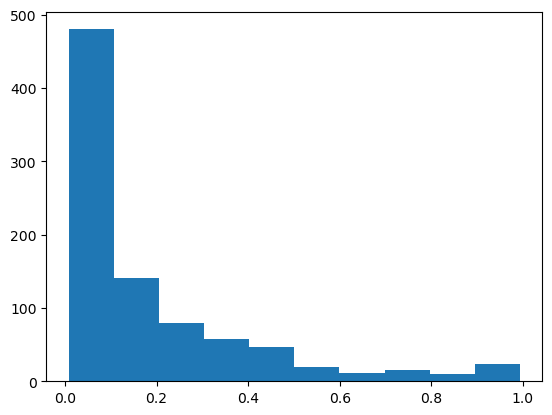

In [76]:
plt.hist(pre)

In [70]:
corr1(torch.tensor(df1["prediction"]), torch.tensor(df2["prediction"])), corr2(torch.tensor(df1["prediction"]), torch.tensor(df2["prediction"]))


(tensor(0.6160), tensor(0.6627))

### test embeddings

In [61]:
path = "/data2/tyfei/trainresults/ionChannels/ESMCFinal/logit/"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)
pretrain_model = trainUtils.loadPretrainModel(configs)
model = trainUtils.buildModel(configs, pretrain_model)

initized model for base_learning stage


In [62]:
ckpt = torch.load("/data2/tyfei/trainresults/ionChannels/ESMCFinal/logit/last.ckpt")
model.load_state_dict(ckpt['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['esm_model.embed.weight', 'esm_model.transformer.blocks.0.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.0.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.0.ffn.0.weight', 'esm_model.transformer.blocks.0.ffn.0.bias', 'esm_model.transformer.blocks.0.ffn.1.linear.weight', 'esm_model.transformer.blocks.0.ffn.3.linear.weight', 'esm_model.transformer.blocks.1.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.1.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.1.ffn.0.weight', 'esm_model.transformer.blocks.1.ffn.0.bias', 'esm_model.transformer.blocks.1.ffn.1.linear.weight', 'esm_model.transformer.blocks.1.ffn.3.linear.weight', 'esm_model.transformer.blocks.2.attn.layernorm_qkv.1.linear.weight', 'esm_model.transformer.blocks.2.attn.out_proj.linear.weight', 'esm_model.transformer.blocks.2.ffn.0.weight', 'esm_model.transformer.blocks.2.ffn.0.bias', 'esm_model.transformer.blocks.2.ffn.1.linear.weight', 'es

In [63]:
ds = trainUtils.loadDataset(configs)
dl = ds.val_dataloader()

get val loader


In [64]:
embed, res = testUtils.getEmbeddings(model.esm_model, dl, 1, 4000, "esmc", "mean")

  0%|          | 0/1975 [00:00<?, ?it/s]

called new epoch


100%|██████████| 1975/1975 [04:14<00:00,  7.76it/s]


In [65]:
import VirusDataset
test = trainUtils.loadPickle("/data/tyfei/datasets/ion_channel/Interprot/test885.pkl")
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
dl = DataLoader(test_set, batch_size=1, shuffle=False) 
embed2, _ = testUtils.getEmbeddings(model.esm_model, dl, 1, 1000, "esmc", "mean")

100%|██████████| 885/885 [00:53<00:00, 16.42it/s]


In [66]:
test = trainUtils.loadPickle("/data/tyfei/datasets/ion_channel/Interprot/Negative_sample/TEST_virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_remain_label2.pkl")
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
dl = DataLoader(test_set, batch_size=1, shuffle=False) 
embed3, _ = testUtils.getEmbeddings(model.esm_model, dl, 1, 1000, "esmc", "mean")

  1%|          | 1000/134200 [00:48<1:47:09, 20.72it/s]


In [67]:
embed.extend(embed2)
embed.extend(embed3)
res.extend(["885"]*885)
res.extend(["virus"]*1000)

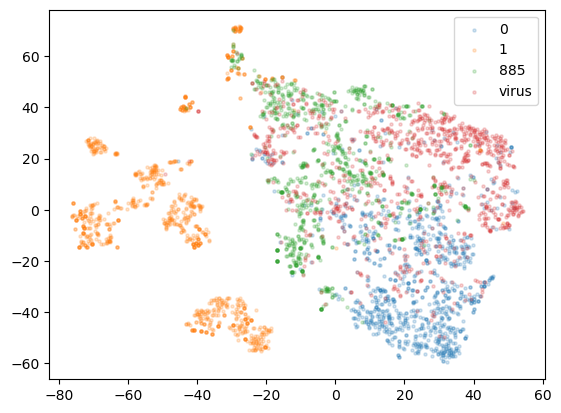

In [68]:
#logits
df = testUtils.tsnedf(embed, res)
df["label"] = df["label"].astype(str)
# df = testUtils.umapdf(embed, res, n_neighbors=25)
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5, alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))

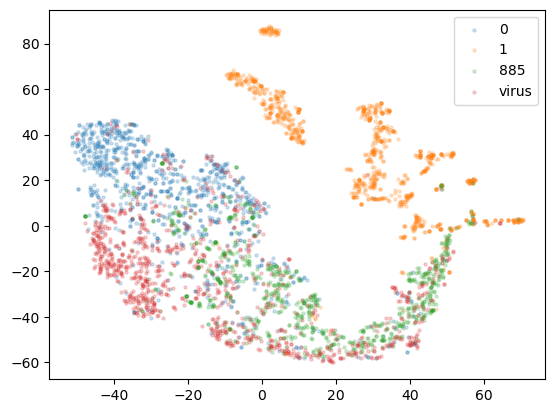

In [60]:
# no adversial
df = testUtils.tsnedf(embed, res)
df["label"] = df["label"].astype(str)
# df = testUtils.umapdf(embed, res, n_neighbors=25)
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5, alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))

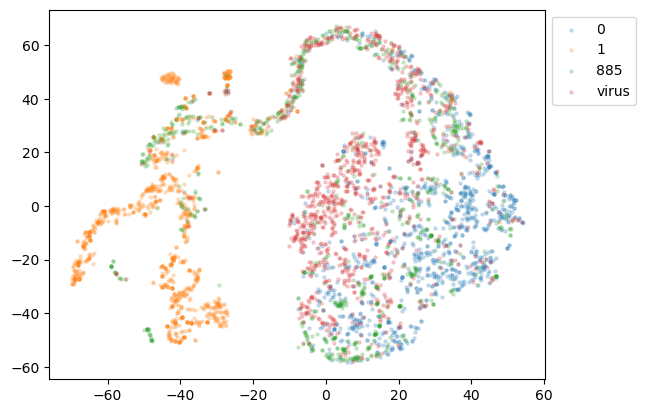

In [52]:
#adversial
df = testUtils.tsnedf(embed, res)
df["label"] = df["label"].astype(str)
# df = testUtils.umapdf(embed, res, n_neighbors=25)
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5, alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))

### test active learning results

In [97]:
corr1 = torchmetrics.PearsonCorrCoef()
corr2 = torchmetrics.SpearmanCorrCoef()

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [104]:
df = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMCActiveLearning/logit2_with_adversial/0/train_2_last.csv")
df.head()

,Voltage-gated,Ligand-gated,Mechanically-gated,Other gating,plasma membrane,endoplasmic reticulum,endosome,apical membrane,golgi,mitochondria,...,K+,Ca2+,Na+,Mg2+,Cl-,H+,Zn2+,F-,Selectivity,prediction
0,0.514709,0.619284,0.056441,0.230708,0.918875,0.042041,0.015227,0.009951,0.027334,0.035137,...,0.327852,0.146480,0.206608,0.310875,0.077796,0.214682,0.107782,0.415784,0.817232,1.0
1,0.518057,0.620170,0.056084,0.233793,0.919893,0.040952,0.014975,0.009837,0.026938,0.035134,...,0.322738,0.142513,0.202369,0.309703,0.076640,0.211065,0.105602,0.418655,0.820194,1.0
2,0.450443,0.599942,0.077123,0.189850,0.886272,0.073581,0.027440,0.012343,0.047475,0.032358,...,0.431382,0.239454,0.307862,0.356540,0.126691,0.304895,0.176813,0.409181,0.735614,1.0
3,0.431946,0.588255,0.090977,0.175513,0.875895,0.087351,0.035288,0.009278,0.058432,0.026860,...,0.465433,0.279254,0.346112,0.387299,0.164087,0.345210,0.217388,0.441006,0.693841,1.0
4,0.441763,0.601005,0.081056,0.189642,0.876580,0.081040,0.030287,0.016628,0.052786,0.035154,...,0.445424,0.256071,0.325193,0.359546,0.132021,0.317938,0.186245,0.396288,0.724014,1.0


In [105]:
corr1(torch.tensor(df["prediction"]), torch.tensor(range(len(df))).float()), corr2(torch.tensor(df["prediction"]), torch.tensor(range(len(df))).float())

(tensor(-0.8387), tensor(-0.9479))

In [99]:
corr1(torch.tensor(df["prediction"]), torch.tensor(range(len(df))).float()), corr2(torch.tensor(df["prediction"]), torch.tensor(range(len(df))).float())

(tensor(-0.1181), tensor(-0.2546))

In [ ]:
t = testUtils.calpermutation()

In [6]:
df = pd.read_csv("/data2/tyfei/trainresults/ionChannels/ESMCActiveLearning/testmodels/4/test_2_last.csv")
df.head()
stats.spearmanr(df["prediction"].values, range(len(df["prediction"].values)))

SignificanceResult(statistic=0.1383566165858347, pvalue=0.5497771220756966)

In [8]:
a = np.loadtxt("/data2/tyfei/trainresults/ionChannels/ESMCActiveLearning/testmodels/5/test_2_last.csv")
stats.spearmanr(a, range(len(a)))

SignificanceResult(statistic=0.3701298701298701, pvalue=0.09862650693576144)

In [5]:
ckpt = torch.load("/data2/tyfei/trainresults/ionChannels/ESMCActiveLearning/FromTestDomain/1/epoch=23-validate_acc=0.98.ckpt")
ckpt["state_dict"].keys()

odict_keys(['additional_label_weights', 'clf.l1.weight', 'clf.l1.bias', 'clf.l2.weight', 'clf.l2.bias', 'clf.l3.weight', 'clf.l3.bias', 'clf.ln1.weight', 'clf.ln1.bias', 'clf.ln2.weight', 'clf.ln2.bias', 'dis.l1.weight', 'dis.l1.bias', 'dis.l2.weight', 'dis.l2.bias', 'dis.l3.weight', 'dis.l3.bias', 'dis.ln1.weight', 'dis.ln1.bias', 'dis.ln2.weight', 'dis.ln2.bias', 'additional_clf.l1.weight', 'additional_clf.l1.bias', 'additional_clf.l2.weight', 'additional_clf.l2.bias', 'additional_clf.l3.weight', 'additional_clf.l3.bias', 'additional_clf.ln1.weight', 'additional_clf.ln1.bias', 'additional_clf.ln2.weight', 'additional_clf.ln2.bias'])

In [9]:
path = "/data2/tyfei/trainresults/ionChannels/ESMC/nodomain" 
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [10]:
pretrain_model = trainUtils.loadPretrainModel(configs)

model = trainUtils.buildModel(configs, pretrain_model, None)

In [11]:
t = torch.load("/data2/tyfei/trainresults/ionChannels/ESMC/nodomain/last.ckpt")
model.load_state_dict(t['state_dict'], strict=False).unexpected_keys

[]

In [21]:
ds = trainUtils.loadDataset(configs)
dl = ds.val_dataloader()

get val loader


In [22]:
embed, res = testUtils.getEmbeddings(model.esm_model, dl, 2, 4000, "esmc", "first")

  0%|          | 0/1975 [00:00<?, ?it/s]

called new epoch


100%|██████████| 1975/1975 [02:12<00:00, 14.89it/s]


In [23]:
import VirusDataset
test = trainUtils.loadPickle("/data/tyfei/datasets/ion_channel/Interprot/test885.pkl")
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
dl = DataLoader(test_set, batch_size=1, shuffle=False) 
embed2, _ = testUtils.getEmbeddings(model.esm_model, dl, 6, 1000, "esmc", "first")

100%|██████████| 885/885 [00:50<00:00, 17.69it/s]


In [ ]:
test = trainUtils.loadPickle("/data/tyfei/datasets/ion_channel/Interprot/Negative_sample/TEST_virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_remain_label2.pkl")
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
dl = DataLoader(test_set, batch_size=1, shuffle=False) 
embed3, _ = testUtils.getEmbeddings(model.esm_model, dl, 6, 1000, "esmc", "first")

  1%|          | 1000/134200 [00:54<2:00:03, 18.49it/s]


In [24]:
embed.extend(embed2)
embed.extend(embed3)
res.extend(["885"]*885)
res.extend(["virus"]*1000)

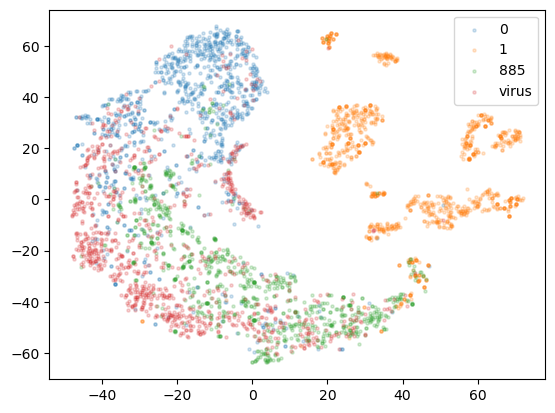

In [26]:
df = testUtils.tsnedf(embed, res)
df["label"] = df["label"].astype(str)
# df = testUtils.umapdf(embed, res, n_neighbors=25)
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5, alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))

In [2]:
t = testUtils.calpermutation(55, 885, 100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:34<00:00, 2920.43it/s]


In [4]:
df = testUtils.ERcorrelation("/data2/tyfei/trainresults/ionChannels/ESMC/newtest/bayes10/test885_last.txt", col="experiment_2")

SignificanceResult(statistic=0.34714177799977236, pvalue=0.005704488756777514)


In [7]:
df = testUtils.yeast("/data2/tyfei/trainresults/ionChannels/ESMC/newtest/bayes10/test885_last.txt", ingore_structure=True)
# df = testUtils.yeast("/data2/tyfei/trainresults/ionChannels/ESMC/domain885/test885_epoch=7-validate_acc=0.txt", ingore_structure=True)
len(df)

55

(array([7., 8., 7., 7., 7., 4., 5., 1., 4., 5.]),
 array([ 11. ,  98.2, 185.4, 272.6, 359.8, 447. , 534.2, 621.4, 708.6,
        795.8, 883. ]),
 <BarContainer object of 10 artists>)

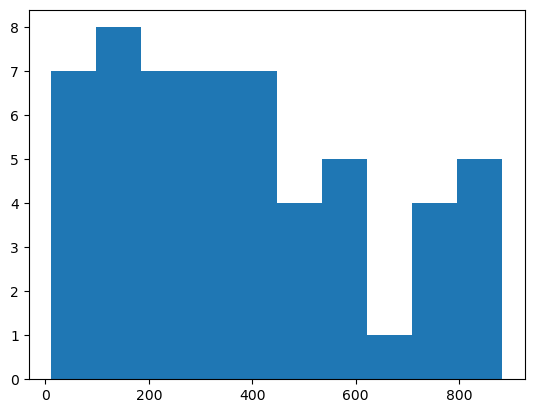

In [8]:
# df[df["is_yeast"]]["rank"]
plt.hist(df["rank"])

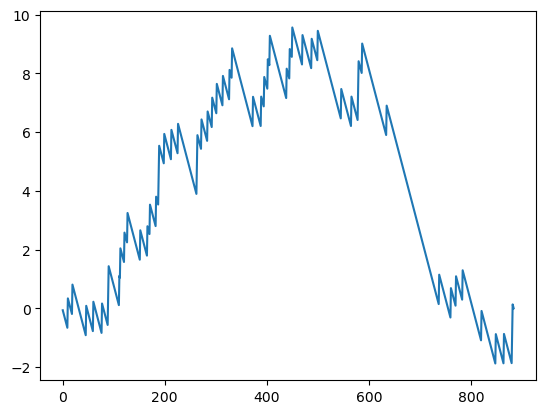

In [10]:
res = testUtils.calres((df["rank"]-1).values, 885)
plt.plot(res)

In [11]:
testUtils.gsea((df["rank"]-1).values, 885, t=t)

0.03967

In [21]:
df = pd.read_csv("temp/res.csv", index_col=0)
df["new"] = a
df = df[["已合成的序列", "预测的序列", "new"]]
# df = df.set_index("已合成的序列")
# df = df.sort_values("new", ascending=False)
# df["rank"] = range(len(df))
df.head()

,已合成的序列,预测的序列,new
0,MKPLCTPWVDGTILCSLLFLLAFSGVSSAWSNDTKLPQRRSGHLRD...,MLSFIALLFIAVVNADVILVQQTSRQNFIGYVTPINSGGNPTDGLL...,0.710556
1,MLRYPWLQLLATFLLFEVSLCCFFSKKGLTTSYNRRFHYRWIQLNR...,MKFSKRNLLIAVMIAVILFLLVRRGVSMASDMTFNPPSGMSCATPA...,0.564458
2,MGRQDTSREGNEDYEDIMRWVRRFVWLTRVYTVLAVQMAVTLAFCL...,MGAKKPKYKNFVHWLDEKSVISVAVAFSVSMAVNRFMQTLIDNLVI...,0.632396
3,MEVLRFQVRFTESIIWIQRFKILIQLYSYWLLQVTVTSTLSTLMWL...,MHIELLFLSLFILLLVWLVMDRTKKGYTSLDNLSNDYYLWRAYNHN...,0.477273
4,MDHRSYADAELAESWMHENLVQWIDRFRSVVAIYSNALFEVAGTLS...,MFSIDIKTQFKYQLILLFSAFFLHMVLSKSGIGTYSKNTPLWYDLF...,0.766280


In [4]:
import random 
from tqdm import tqdm

def cales(pos, total):
    t=-100000
    es = 0
    for i in range(total):
        if i in pos:
            es+=1
        else:
            es-=len(pos)/(total-len(pos)) 
        if es>t:
            t=es
    return t

def calres(pos, total):
    t=-100000
    es = 0
    res = []
    for i in range(total):
        if i in pos:
            es+=1
        else:
            es-=len(pos)/(total-len(pos)) 
        if es>t:
            t=es
        res.append(es)
    return res


def calpermutation(pos, total, permutation=100000):
    res = []
    for i in tqdm(range(permutation)):
        q = random.sample(range(total), pos)
        t = cales(q, total)
        res.append(t)
    return res

def gsea(pos, total, permutation=100000, t=None):
    es = cales(pos, total)
    cnt = 0
    if t is None:
        for i in tqdm(range(permutation)):
            q = random.sample(range(total), len(pos))
            t = cales(q, total)
            if t>=es:
                cnt+=1
        return cnt/permutation
    else:
        for i in t:
            if i>=es:
                cnt+=1
        return cnt/len(t)

t = calpermutation(69, 885, 100000)

100%|██████████| 100000/100000 [00:39<00:00, 2513.92it/s]


In [ ]:
path = "/data2/tyfei/trainresults/ionChannels/ESMC/noLora/test885_epoch=27-validate_acc=0.txt"
a = np.loadtxt(path) 
df = pd.read_csv("temp/res.csv", index_col=0)
df["new"] = a
df = df[["已合成的序列", "预测的序列", "new"]]  
df = df.sort_values("new", ascending=False)
df["rank"] = range(len(df)) 

In [9]:
dfyeast = pd.read_excel("temp/1210_对应信息.xlsx", index_col=0, sheet_name="Yeast screening")
# dfyeast = dfyeast.set_index("seq")
df["yeast"] = df["已合成的序列"].apply(lambda x: x in dfyeast["seq"].values)
q = df[df["yeast"] == True]
q

,已合成的序列,预测的序列,new,rank,yeast
828,MSLLTEVETPTRSEWECRCSDSSDPLVIAANIIGILHLILWITDRL...,MPNKITFGASVLASAATAFGLGALAFTSPNAPETAYPLPTHSAPDV...,0.982459,1,True
725,ASFAEGMAYLWDNNQSMFWMELTGPLALLILATCCARSLLSCCKGS...,MWGRKNNIHCCALCTNVLAMHTYFWLLCYLLLPAPGGLGAPVGTGG...,0.889126,26,True
569,MVRRVLLERVDGIVEHSRADRRYLEAIQRHLEGSTPGLRQMWRFIY...,MYNKLVFCICSINKNILTYNIFYYCTTFNIITSFFNFIASSLLMCH...,0.846832,43,True
246,MWNVMISFSMGLVLGNVIPGESCFHLMIKKTLFEQVVLIFLFSGGL...,MPCKPGVYRRMWDHGILRQGRESNIIFLVHGWHGVQSSFKMFFPML...,0.843932,44,True
753,ASVAETMAYLWDQNQALFWLEFAAPVACILIITYCLRNVLCCCKSL...,MANLWKNDNCWNIPYKCYTLTLWIYMNIAKFVTKLIQIHLRNGFRT...,0.827042,54,True
...,...,...,...,...,...
789,MATLEELQKEINNHEGQLVIARQKVKDAEKQYEKDPDDLNKRALSD...,MVRSFFSLVVIAIGRYFESFFIAMLCCQEQINIRMRTFRYSYTFWS...,0.027098,837,True
618,MAKNNNEMLLDVPIYIIPIVNRGVKSVIPEYEADKKNVEIDEIKDD...,MKIILFLTLIVFTSCELYHYQECVRGTTVLLKEPCPSGTYEGNSPF...,0.019504,865,True
868,MMMASKDAPTNMDGTSGAGQLVPEANTAEPISMEPVAGAATAAATA...,MIVVNYLISCILYIYSNFIQTFKLSVNTTFHIKCVSSFLLVPTQTT...,0.017396,869,True
625,MNPSSVFLIVVATVAICLIVIQVYYIYENYDNIKEFNSTHSLLEYS...,MYIMDLKLSLIIVCFLNFIWKTAIIVSGLLYLSIICKIEIITLLAI...,0.015676,874,True


0.00058

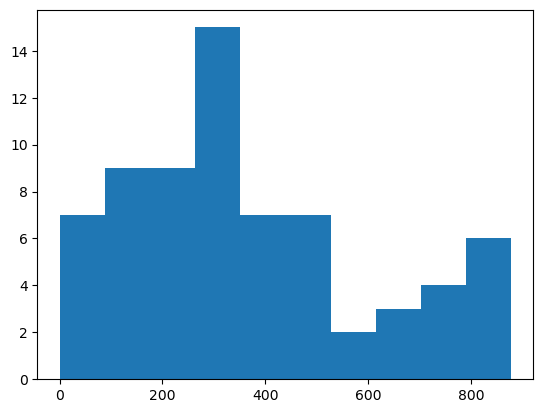

In [10]:
import matplotlib.pyplot as plt
plt.hist(q["rank"].values, bins=10)
calres(q["rank"].values, 885)
gsea(q["rank"].values, 885, t = t)

In [15]:
dfexp = pd.read_excel("./temp/1210_对应信息.xlsx", sheet_name="Sheet1")
df = df.set_index("已合成的序列")
dfexp["new"] = dfexp["蛋白质序列.1"].map(df["new"])
dfexp.head()

,质粒的名称,蛋白质序列,蛋白质序列.1,new
0,VILH-301,GSMPPQRARGAPPRRRGSDPPDPGSLAGRLSPGGRSGGGSRRTLSR...,MPPQRARGAPPRRRGSDPPDPGSLAGRLSPGGRSGGGSRRTLSRSS...,0.282114
1,VILH-197,GSMRASKSDRFLMSSWVKLLFVAVIMYICSAVVPMAATYEGLGFPC...,MRASKSDRFLMSSWVKLLFVAVIMYICSAVVPMAATYEGLGFPCYF...,0.542363
2,VILH-19,GSMAPSKVDSVNSRIWGISVFLAFLTFANICGHTTMMNVPGVGYPC...,MAPSKVDSVNSRIWGISVFLAFLTFANICGHTTMMNVPGVGYPCSY...,0.139934
3,VILH-363,GSMDAVSALCVALASAAAMFVALQMWAVYENYDNIREFNSANAALE...,MDAVSALCVALASAAAMFVALQMWAVYENYDNIREFNSANAALEFA...,0.103598
4,VILH-426,GSMDKTTLSVNACNLEYVREKAIVGVQAAKTSTLIFFVIILAISAL...,MDKTTLSVNACNLEYVREKAIVGVQAAKTSTLIFFVIILAISALLL...,0.067235


In [16]:
dfexp2 = pd.read_excel("./temp/1210_对应信息.xlsx", sheet_name="Sheet2")
# dfexp["new"] = dfexp["蛋白质序列.1"].map(df["new"])
dfexp2["rank"] = range(len(dfexp2))
dfexp2["rank"] = -dfexp2["rank"]
dfexp2.head()

,Name,final_p,rank
0,VILH-828,0.964103,0
1,VILH-53,0.951250,-1
2,VILH-791,0.845549,-2
3,VILH-295,0.106237,-3
4,VILH-284,0.092133,-4


In [17]:
dfexp["rank"] = dfexp["质粒的名称"].map(dfexp2.set_index("Name")["rank"])
dfexp

,质粒的名称,蛋白质序列,蛋白质序列.1,new,rank
0,VILH-301,GSMPPQRARGAPPRRRGSDPPDPGSLAGRLSPGGRSGGGSRRTLSR...,MPPQRARGAPPRRRGSDPPDPGSLAGRLSPGGRSGGGSRRTLSRSS...,0.282114,-101
1,VILH-197,GSMRASKSDRFLMSSWVKLLFVAVIMYICSAVVPMAATYEGLGFPC...,MRASKSDRFLMSSWVKLLFVAVIMYICSAVVPMAATYEGLGFPCYF...,0.542363,-85
2,VILH-19,GSMAPSKVDSVNSRIWGISVFLAFLTFANICGHTTMMNVPGVGYPC...,MAPSKVDSVNSRIWGISVFLAFLTFANICGHTTMMNVPGVGYPCSY...,0.139934,-89
3,VILH-363,GSMDAVSALCVALASAAAMFVALQMWAVYENYDNIREFNSANAALE...,MDAVSALCVALASAAAMFVALQMWAVYENYDNIREFNSANAALEFA...,0.103598,-95
4,VILH-426,GSMDKTTLSVNACNLEYVREKAIVGVQAAKTSTLIFFVIILAISAL...,MDKTTLSVNACNLEYVREKAIVGVQAAKTSTLIFFVIILAISALLL...,0.067235,-96
...,...,...,...,...,...
101,VILH-537,GSMEVIADRLDDIVKQNIADEKFVDFVIHGLEHQCPAILRPLIRLF...,MEVIADRLDDIVKQNIADEKFVDFVIHGLEHQCPAILRPLIRLFID...,0.878230,-7
102,VILH-284,GSMVRARVLRGLLAAWVLAAWGGVAAVETTWKHASAGDDVRFFDLP...,MVRARVLRGLLAAWVLAAWGGVAAVETTWKHASAGDDVRFFDLPAG...,0.051584,-4
103,VILH-791,GSMGNTSITIEFTSKFWPYFTLIHMILTLISLLIIITIMIAILNKL...,MGNTSITIEFTSKFWPYFTLIHMILTLISLLIIITIMIAILNKLSE...,0.768537,-2
104,VILH-828,GSMNNATFNCTNINPITHIRGSIIITICVSLIVILIVFGCIAKIFI...,MNNATFNCTNINPITHIRGSIIITICVSLIVILIVFGCIAKIFINK...,0.188189,0


In [18]:
from scipy import stats
stats.spearmanr(dfexp["new"], dfexp["rank"])

SignificanceResult(statistic=-0.022565936972567195, pvalue=0.8183986873586666)

In [2]:
a = pd.DataFrame({"a":[1,2,3]})
a

,a
0,1
1,2
2,3


In [2]:
import random
random.seed(1509)
torch.manual_seed(1509)

In [27]:
import json
import os
import trainUtils 
path = "/home/tyfei/ionChannel/ckptsesm3/Loraall/"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

pretrain_model = trainUtils.loadPretrainModel(configs) 
model = trainUtils.buildModel(configs, pretrain_model, "/home/tyfei/ionChannel/ckptsesm3/Loraall/last.ckpt")

In [ ]:
from tqdm import tqdm
def getEmbeddings(model, dl, device, trunc=30000):
    res = [] 
    model = model.to(device)
    model.eval()
    pbar = tqdm(dl)
    cnt = 0
    for i, j in enumerate(pbar):
        cnt += 1
        if cnt == trunc:
            break
        
        for track in ["sequence_t", "structure_t", "ss8_t", "sasa_t"]:
            if track not in j:
                j[track] = None
            else:
                j[track] = j[track].to(device)
                if len(j[track].size()) == 1:
                    j[track] = j[track].unsqueeze(0)
        
        representations = model(
            sequence_tokens=j["sequence_t"],
            structure_tokens=j["structure_t"],
            ss8_tokens=j["ss8_t"],
            sasa_tokens=j["sasa_t"],
        )
        representations = representations.embeddings[:, 0]
        res.append(representations.cpu().numpy()) 
    return res


In [18]:
pos = ["/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Archaea.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Bacteria.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Eukaryota.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/interpro.pkl",
        "/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/profile.pkl"
    ]
neg = ["/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_noTMHMM.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_TMHMM_keywords.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_keywords_norefseq.pkl", 
        "/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl"
    ]
tests = ["/data/yangziyue/Ion_channel/data/TEST_refseq_rmdup_mmseq_TMHMM.pkl"]
names = ["Archaea", "Bacteria", "Eukaryota", "interpro", "profile", "refseq_rmdup_mmseq_noTMHMM", "refseq_rmdup_mmseq_TMHMM_keywords", "virus_proteins_rmdup_clean_X0", "interpro_neg", "test885"]

In [6]:
embeds = [] 
labels = [] 

In [51]:
test = trainUtils.loadPickle("/data/tyfei/datasets/ion_channel/Interprot/test885.pkl")
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
dl = DataLoader(test_set, batch_size=1, shuffle=False) 

In [53]:
for j in dl:
    print(j)
    break

{'seq_t': tensor([[ 0, 20, 15, 14,  4, 23, 11, 14, 22,  7, 13,  6, 11, 12,  4, 23,  8,  4,
          4, 18,  4,  4,  5, 18,  8,  6,  7,  8,  8,  5, 22,  8, 17, 13, 11, 15,
          4, 14, 16, 10, 10,  8,  6, 21,  4, 10, 13, 21,  5,  9, 11, 10, 14,  4,
          8,  6,  8,  8,  8,  8, 14, 11, 23, 13, 10, 16, 23, 14,  4, 10, 13, 13,
          8, 14,  5, 23, 17,  5, 18,  4,  9,  8, 19,  9, 10,  5,  7, 16,  4,  4,
          6, 23, 13, 14, 16,  4, 15, 21, 10, 21,  7,  4,  6, 14, 10,  6,  4, 18,
          6, 23, 14, 15,  5, 14, 10,  6,  7,  4,  7,  4,  4,  9, 21, 19,  6,  6,
          4, 11,  4,  4,  7, 19, 20,  5,  4, 12,  4, 18,  5,  7,  7, 18, 11,  8,
          4, 20,  4, 19,  7, 20, 13,  9, 23, 13, 12,  5, 10, 21,  5, 10, 10, 23,
          6,  8, 21,  2]]), 'structure_t': tensor([[4098, 3425,  256, 2529, 3332, 3425, 3479, 1316, 1800, 2866, 3147,  975,
         3309,  588, 3310, 1627, 1720, 2279, 2098, 3759,  868, 2842, 1379, 1656,
         1035, 2874,  985, 2842, 2874, 1476, 1938, 3932,

In [10]:
for i in pos:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_train.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_train.pkl"%name, "wb") as f:
        pickle.dump(t, f)
        
for i in neg:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_train.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_train.pkl"%name, "wb") as f:
        pickle.dump(t, f)
        
for i in tests:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    if os.path.exists("./temp/%s_train.pkl"%name):
        continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_train.pkl"%name, "wb") as f:
        pickle.dump(t, f)


/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Archaea.pkl Archaea
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Bacteria.pkl Bacteria
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Eukaryota.pkl Eukaryota
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/interpro.pkl interpro
/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/profile.pkl profile
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_noTMHMM.pkl refseq_rmdup_mmseq_noTMHMM
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/refseq_rmdup_mmseq_TMHMM_keywords.pkl refseq_rmdup_mmseq_TMHMM_keywords
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_rmdup_clean_X0.1_TMHMM_mmseq_keywords_norefseq.pkl virus_proteins_rmdup_clean_X0
/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl interpro_neg
/data/yangziyue/Ion_channel/data/TEST_refseq_rmdup

100%|██████████| 18466/18466 [19:52<00:00, 15.48it/s]


In [5]:
with open("./temp/%s_train.pkl"%"test885", "rb") as f:
    a = pickle.load(f)
a[0].shape

(1, 1536)

In [19]:
labels = [] 
embeds = []
for i in names:
    print(i)
    with open("./temp/%s_train.pkl"%i, "rb") as f:
        a = pickle.load(f) 
    labels.extend([i]*len(a)) 
    embeds.extend(a) 
    print(len(labels))

Archaea
651
Bacteria
8265
Eukaryota
34682
interpro
52694
profile
53244
refseq_rmdup_mmseq_noTMHMM
83243
refseq_rmdup_mmseq_TMHMM_keywords
83674
virus_proteins_rmdup_clean_X0
86495
interpro_neg
116494
test885
117379


In [20]:
len(labels)

117379

In [33]:
embeds = [] 
labels = []
for i in ["/home/tyfei/datasets/ion_channel/Interprot/test885.pkl"]:
    name = os.path.basename(i)
    name = name[:name.find(".")]
    print(i, name)
    # if os.path.exists("./temp/%s_train.pkl"%name):
    #     continue
    test = trainUtils.loadPickle(i)
    test_set = VirusDataset.ESM3MultiTrackDatasetTEST(test) 
    dl = DataLoader(test_set, batch_size=1, shuffle=False) 
    with torch.no_grad():
        t = getEmbeddings(pretrain_model, dl, "cuda:0")
        embeds.extend(t) 
        labels.extend([name]*len(test))
    with open("./temp/%s_train.pkl"%name, "wb") as f:
        pickle.dump(t, f)

/home/tyfei/datasets/ion_channel/Interprot/test885.pkl test885


100%|██████████| 885/885 [01:11<00:00, 12.38it/s]


In [21]:
q = np.array(embeds)
q = q.squeeze()
q.shape

(117379, 1536)

In [22]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=30) 
pca_seq = pca.fit_transform(q)
pca_seq.shape
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

In [36]:
df2 = pd.read_csv("/home/tyfei/ionChannel/ckptsesm3/Loraall/e15/test885_last.txt", header=None)
df2.head()

,0
0,0.100184
1,0.166719
2,0.531101
3,0.927584
4,0.188885


In [12]:
df = pd.DataFrame({"x":X_embedded[:, 0], "y":X_embedded[:, 1], "label":labels})
# df["class"] = df["label"].map({1:"Ion channel", 0:"non ion channel", 2:"Virus"})
df.head()

,x,y,label
0,-71.074577,9.736429,Archaea
1,-29.565126,68.458458,Archaea
2,-43.039555,-8.764258,Archaea
3,-31.062923,-28.060915,Archaea
4,-33.304413,-30.026848,Archaea


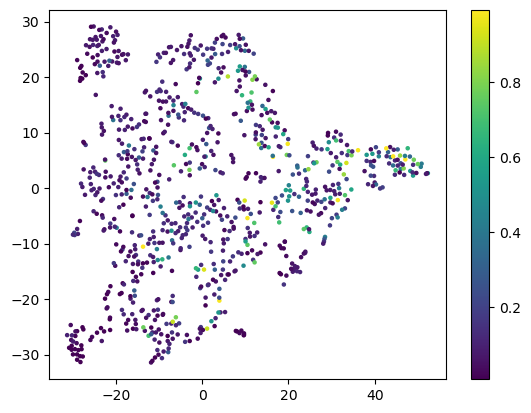

In [38]:
import matplotlib.pyplot as plt
plt.scatter(df["x"], df["y"], s=5, c=df["label"])
plt.colorbar()
# plt.legend()

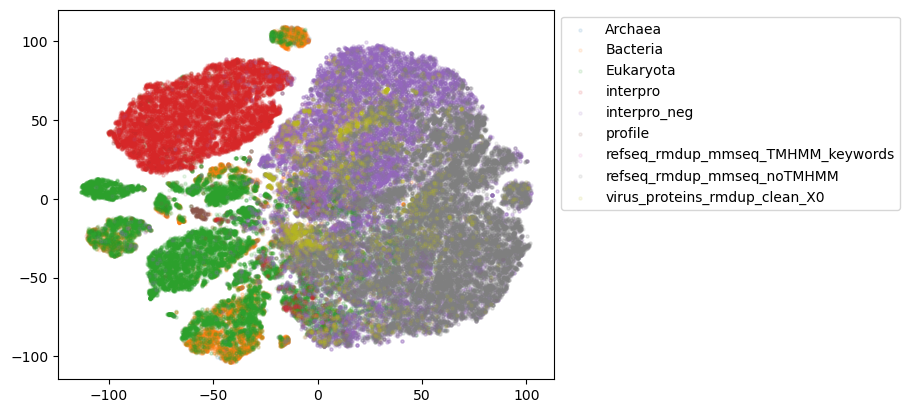

In [15]:
import matplotlib.pyplot as plt
for i in np.unique(df["label"]):
    subdf = df[df["label"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5, alpha=0.1)
plt.legend(bbox_to_anchor=(1,1))

In [23]:

# testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/virus_proteins_TMHMM_keywords.pkl")
# testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/interpro_neg.pkl")
testdata = trainUtils.loadPickle("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/mmseqs_kingdom/Viruses.pkl")
# step_points = configs["augmentation"]["step_points"]
# crop = configs["augmentation"]["crop"]
# maskp = [
#     (i, j)
#     for i, j in zip(
#         configs["augmentation"]["maskp"], configs["augmentation"]["maskpc"]
#     )
# ]
# aug = VirusDataset.DataAugmentation(step_points, maskp, crop, lens)
print(len(testdata))
test_set = VirusDataset.ESM3MultiTrackDatasetTEST(testdata, tracks=["seq_t"]) 

dl = DataLoader(test_set, batch_size=1, shuffle=False) 

122


In [20]:
testdata[3].keys()

dict_keys(['randomseed', 'model', 'id', 'ori_seq', 'seq_t', 'second_t', 'sasa_t', 'coordinates', 'origin', 'structure_t'])

In [24]:
trainer = L.Trainer(accelerator="gpu", devices=[3]) 
res = trainer.predict(model, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 122/122 [00:06<00:00, 18.57it/s]


(array([30., 10.,  4.,  1.,  5.,  2.,  0.,  5., 12., 53.]),
 array([0.00141849, 0.10094205, 0.20046562, 0.29998919, 0.39951274,
        0.49903631, 0.59855986, 0.69808346, 0.797607  , 0.89713061,
        0.99665415]),
 <BarContainer object of 10 artists>)

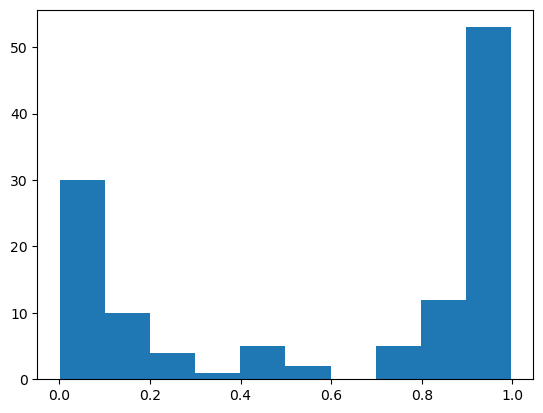

In [25]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([8839.,  297.,  137.,   80.,   70.,   55.,   43.,   69.,   74.,
          28.]),
 array([0.00140808, 0.10092815, 0.20044823, 0.2999683 , 0.39948839,
        0.49900848, 0.59852856, 0.69804859, 0.79756868, 0.89708877,
        0.99660885]),
 <BarContainer object of 10 artists>)

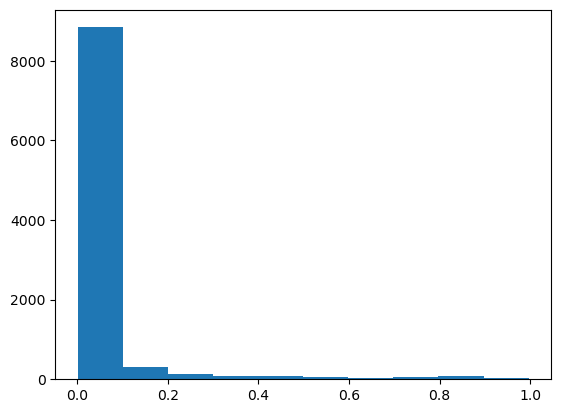

In [22]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([12.,  9.,  6.,  3., 12.,  3.,  6.,  1.,  4., 66.]),
 array([0.00230605, 0.10174943, 0.2011928 , 0.30063617, 0.40007955,
        0.49952292, 0.5989663 , 0.69840968, 0.79785305, 0.89729643,
        0.9967398 ]),
 <BarContainer object of 10 artists>)

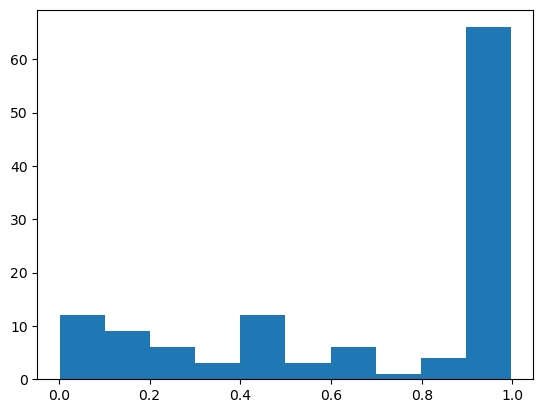

In [15]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([5591.,  690.,  411.,  333.,  450.,  400.,  358.,  383.,  371.,
         705.]),
 array([0.00228902, 0.10173409, 0.20117915, 0.30062422, 0.4000693 ,
        0.49951434, 0.59895945, 0.69840449, 0.79784954, 0.89729464,
        0.99673969]),
 <BarContainer object of 10 artists>)

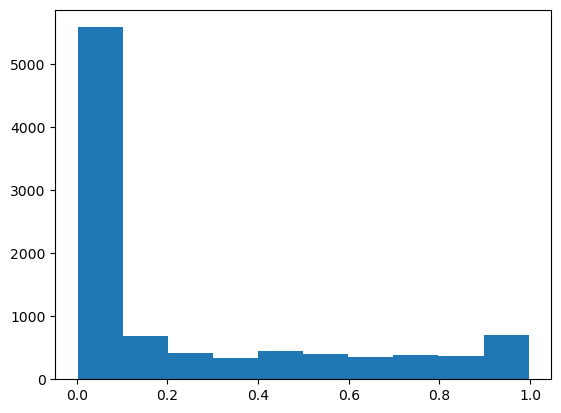

In [12]:
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([5546.,  535.,  299.,  210.,  221.,  185.,  203.,  290.,  613.,
        1590.]),
 array([0.00207064, 0.10166105, 0.20125145, 0.30084187, 0.40043226,
        0.50002265, 0.59961307, 0.69920349, 0.79879391, 0.89838427,
        0.99797469]),
 <BarContainer object of 10 artists>)

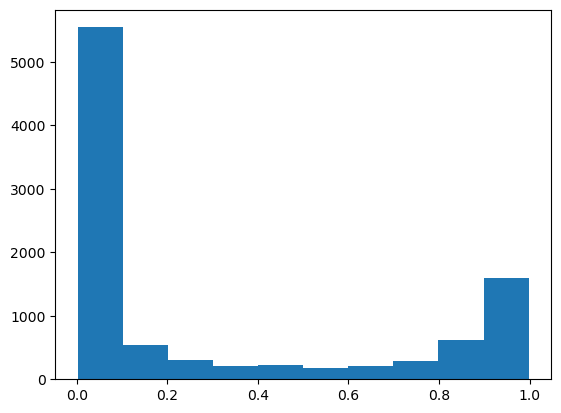

In [20]:
#Lora5mean
pre = torch.stack(res).numpy()
len(pre)
import matplotlib.pyplot as plt
plt.hist(pre)

(array([2394.,  514.,  303.,  264.,  243.,  277.,  274.,  337.,  742.,
        4344.]),
 array([0.00120502, 0.1009583 , 0.20071156, 0.30046484, 0.40021813,
        0.49997139, 0.59972465, 0.69947791, 0.79923123, 0.89898449,
        0.99873775]),
 <BarContainer object of 10 artists>)

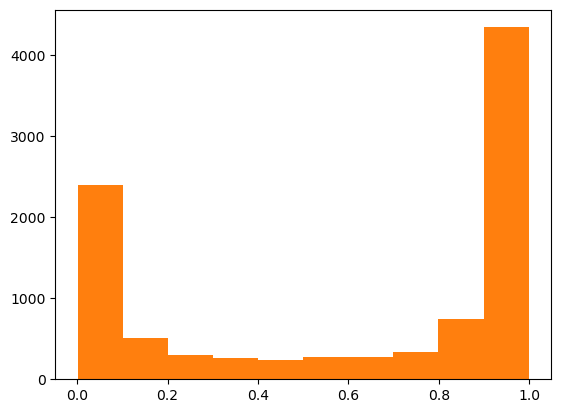

In [16]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([3793.,  545.,  359.,  300.,  209.,  243.,  266.,  377.,  724.,
        2876.]),
 array([0.00154487, 0.10118137, 0.20081787, 0.30045438, 0.40009087,
        0.49972737, 0.59936386, 0.69900036, 0.79863685, 0.89827335,
        0.99790984]),
 <BarContainer object of 10 artists>)

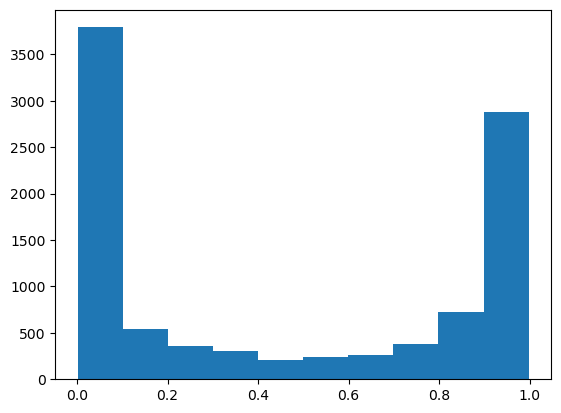

(array([422.,   2.,   1.,   2.,   0.,   1.,   1.,   0.,   1.,   1.]),
 array([0.00154836, 0.10029714, 0.19904591, 0.2977947 , 0.39654347,
        0.49529225, 0.59404105, 0.69278979, 0.7915386 , 0.89028734,
        0.98903614]),
 <BarContainer object of 10 artists>)

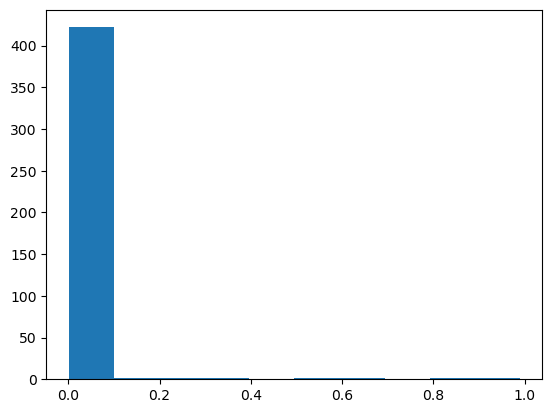

In [18]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([2.775e+03, 2.000e+01, 8.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 5.000e+00, 3.000e+00]),
 array([0.00154398, 0.09642326, 0.19130255, 0.28618184, 0.38106111,
        0.47594041, 0.57081968, 0.66569895, 0.76057827, 0.85545754,
        0.95033681]),
 <BarContainer object of 10 artists>)

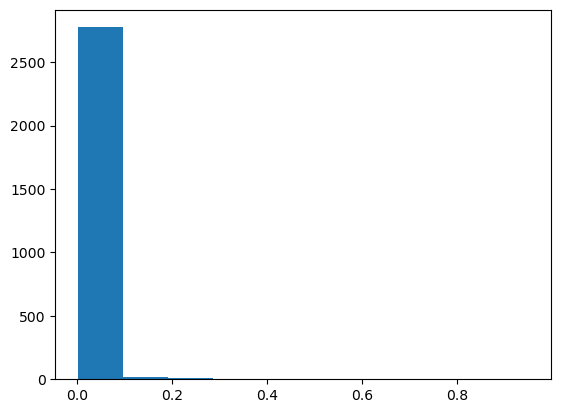

In [14]:
import matplotlib.pyplot as plt
plt.hist(pre)

(array([16.,  5.,  4.,  0.,  1.,  4.,  0.,  5.,  4., 83.]),
 array([0.00157986, 0.10121261, 0.20084538, 0.30047813, 0.40011087,
        0.49974364, 0.59937638, 0.69900912, 0.79864192, 0.89827466,
        0.9979074 ]),
 <BarContainer object of 10 artists>)

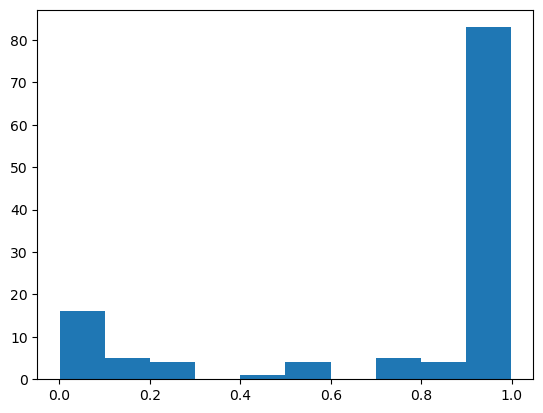

In [9]:
import matplotlib.pyplot as plt
plt.hist(pre)

In [44]:
pre = torch.concatenate(res).numpy()
len(pre)

678063

In [46]:
ids = [] 
dess = [] 
oris = []
for (id, des, ori) in X2_labels:
    ids.append(id)
    dess.append(des)
    oris.append(ori)
df = pd.DataFrame({"id":ids, "description":dess, "origanism":oris, "predict":pre})
df.head()

,id,description,origanism,predict
0,YP_009026398.1,"Arhar cryptic virus-I segment RNA-3, strain Hy...",ORGANISM Arhar cryptic virus-I Viruses. .,0.019432
1,YP_009956140.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.018958
2,YP_009956141.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.029809
3,YP_009956142.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.032612
4,YP_009956143.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.040137


In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

# Example Dataset
class RandomDataset(Dataset):
    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len


# Lightning Module
class MyModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(32, 1)

    def forward(self, x):
        return self.layer(x)

    def training_step(self, batch, batch_idx, dataloader_idx=0):
        # Simple MSE loss
        # print(batch)
        print(dataloader_idx, batch[0][0][0])
        batch = batch[0]
        output = self(batch)
        loss = torch.nn.functional.mse_loss(output, torch.ones_like(output))
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        # Validation step for each dataloader
        output = self(batch)
        val_loss = torch.nn.functional.mse_loss(output, torch.ones_like(output))
        self.log(f"val_loss_dataloader_{dataloader_idx}", val_loss)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01)

    def train_dataloader(self):
        # Single training dataloader
        train_dataset1 = RandomDataset(32, 16)
        train_dataset2 = RandomDataset(32, 2000)
        train_dataloader1 = DataLoader(train_dataset1, batch_size=16)
        train_dataloader2 = DataLoader(train_dataset2, batch_size=16)
        
        return [train_dataloader1, train_dataloader2]

    def val_dataloader(self):
        # Multiple validation dataloaders
        val_dataset_1 = RandomDataset(32, 400)
        val_dataset_2 = RandomDataset(32, 300)
        val_loader_1 = DataLoader(val_dataset_1, batch_size=32)
        val_loader_2 = DataLoader(val_dataset_2, batch_size=32)
        return [val_loader_1, val_loader_2]


# Train the model
model = MyModel()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | layer | Linear | 33     | train
-----------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 125/125 [00:00<00:00, 174.85it/s, v_num=626]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 125/125 [00:00<00:00, 173.67it/s, v_num=626]


In [17]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.utilities.combined_loader import CombinedLoader

# Define two simple datasets
class RandomDataset(Dataset):
    def __init__(self, size, length):
        self.data = torch.randn(length, size)
        self.labels = torch.randint(0, 2, (length,))  # Binary labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Define the LightningModule
class MultiDataloaderModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Define two simple models for two dataloaders
        self.model1 = torch.nn.Linear(32, 2)  # For dataloader 1
        self.model2 = torch.nn.Linear(32, 1)  # For dataloader 2

    def forward(self, x):
        return x  # Not used directly in this example

    def training_step(self, batch, batch_idx, dataloader_idx=0):
        print(batch)
        inputs, targets = batch[0]

        # if dataloader_idx == 0:  # First dataloader
        outputs = self.model1(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        self.log("train_loss_loader_1", loss, on_step=True, on_epoch=True)
        # elif dataloader_idx == 1:  # Second dataloader
        #     outputs = self.model2(inputs).squeeze()
        #     loss = torch.nn.functional.mse_loss(outputs, targets.float())
        #     self.log("train_loss_loader_2", loss, on_step=True, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        # Use a single optimizer for simplicity
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def train_dataloader(self):
        # Define two datasets
        dataset1 = RandomDataset(32, 1000)
        dataset2 = RandomDataset(32, 800)
        
        # Create dataloaders for both datasets
        dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=True)
        dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=True)
        
        # Combine both dataloaders
        combined_loader = CombinedLoader(
            [dataloader1, dataloader2],
            mode="max_size"  # Ensures cycling through both dataloaders
        )
        return combined_loader


# Train the model
if __name__ == "__main__":
    # Create the PyTorch Lightning trainer
    trainer = pl.Trainer(
        max_epochs=5,
        log_every_n_steps=10,
        accelerator="cpu"  # Change to "gpu" if you have a GPU
    )

    # Initialize the model
    model = MultiDataloaderModel()

    # Train the model
    trainer.fit(model)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | model1 | Linear | 66     | train
1 | model2 | Linear | 33     | train
------------------------------------------
99        Trainable params
0         Non-trainable params
99        Total params
0.000     Total estimated model params size (MB)
/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s] [[tensor([[ 0.0816,  0.6082, -1.9528,  ...,  0.0127, -0.0511,  1.7400],
        [ 0.7971,  2.3362, -0.4384,  ...,  0.5813,  0.6092, -0.4528],
        [-1.1627, -0.1879, -0.3423,  ...,  1.0994, -0.7537, -2.0905],
        ...,
        [-0.8856, -0.0281,  0.3009,  ...,  0.9066,  0.2092,  3.7941],
        [ 0.8878, -0.2259, -0.7085,  ..., -1.2086, -0.3142, -0.0731],
        [ 1.2692, -0.3451, -1.4513,  ..., -0.2238,  0.9171,  0.4035]]), tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1])], [tensor([[-0.5823,  0.5676,  1.2491,  ...,  0.5190, -0.2406, -0.2171],
        [ 1.4257, -0.4398,  0.7546,  ..., -0.0681,  0.2917,  0.6697],
        [ 1.5282, -0.3654,  0.4772,  ...,  0.4489, -0.0358,  0.7836],
        ...,
        [ 1.6944,  0.5036,  1.1519,  ...,  1.6705, -0.0305, -1.4556],
        [-0.2065, -0.3301,  0.6862,  ..., -0.4871,  0.9213,  0.4140],
        [ 1.1590, -0.7588, -0.7749, 

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


[[tensor([[-0.6684, -0.5126,  2.4459,  ..., -2.6724, -2.4637, -0.8541],
        [ 0.0983, -0.9360, -0.9878,  ...,  0.8853,  0.9787, -0.8608],
        [-0.6138, -1.1841, -1.7356,  ...,  0.1410, -0.6497,  0.7919],
        ...,
        [-2.1786,  0.1012,  1.0936,  ..., -0.8216,  0.1184, -0.3253],
        [-1.2345,  0.5789,  0.8464,  ..., -0.1116, -1.0966, -2.5097],
        [ 0.6360, -0.2254, -0.5928,  ..., -0.6083,  0.3049,  0.0240]]), tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0])], [tensor([[ 0.9665,  1.2209,  1.5048,  ...,  0.7767,  0.4593, -0.2964],
        [-0.5596,  2.1120,  0.3366,  ...,  0.2056, -1.2179,  2.3610],
        [ 1.3177,  0.2849, -0.8351,  ...,  0.1789,  0.0240, -1.2815],
        ...,
        [-2.6859,  0.1809, -0.8077,  ...,  1.2240,  0.4681, -0.8761],
        [ 1.0843, -3.1121, -0.3837,  ..., -0.5058,  0.8909, -1.0702],
        [ 1.4815, -1.2000,  0.5917,  ...,  0.5514,  1.7038, -0.5022]]), tensor([0, 0

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 223.60it/s, v_num=633]
